In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import os

In [2]:
def plot_loss(history):
    plt.figure(figsize=(10,10))
    epochs = np.arange(len(history.history['loss']))+1
    plt.subplot(211)
    plt.plot(epochs-0.5, history.history['loss'], label='Loss')
    plt.plot(epochs, history.history['val_loss'], label='Val. Loss')
    plt.legend()
    plt.subplot(212)
    plt.plot(epochs-0.5, history.history['accuracy'], label='Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Val. Accuracy')
    plt.legend()

In [3]:
data_filepath = '../input/titanic/train.csv'
raw_data = pd.read_csv(data_filepath)
raw_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
#Find useful coding for ticket
print(raw_data.info())

#Find distribution of first character of each ticket
first_chars={}
for obj in raw_data['Ticket']:
#     try:
#         if type(int(str(obj[0])))==int:
#             first_chars['numbers'] += 1
#     except:
    try:
        first_chars[str(obj)[0]] += 1
    except:
        first_chars[str(obj)[0]] = 1
for key in sorted(first_chars):
    print('{}: {}'.format(key, first_chars[key]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
1: 146
2: 183
3: 301
4: 10
5: 3
6: 6
7: 9
8: 2
9: 1
A: 29
C: 47
F: 7
L: 4
P: 65
S: 65
W: 13


(array([261.,   0.,   0., 146.,   0.,   0., 183.,   0.,   0., 301.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

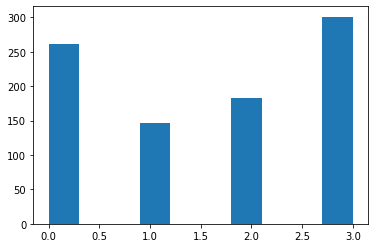

In [5]:
# Code tickets to 1, 2, 3, or 0 if starting with anything else
raw_data['coded_ticket'] = raw_data['Ticket'].map(lambda x: 0 if not str(x)[0].isdigit() else 0 if int(str(x)[0])>3 else int(str(x[0])))
plt.hist(raw_data['coded_ticket'])

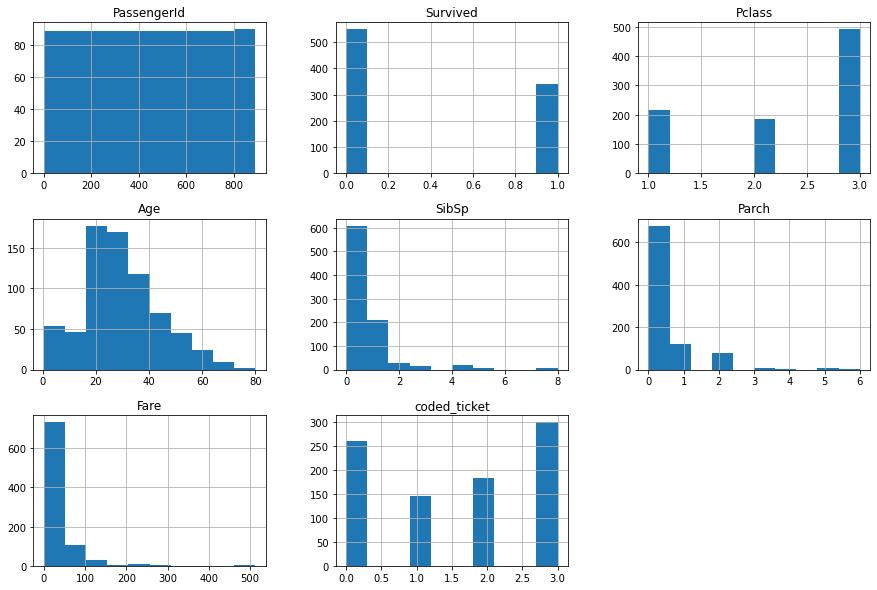

In [6]:
figsize=(15,10)
raw_data.hist(column=raw_data.columns, figsize=figsize);

In [7]:
corr_matrix = raw_data.corr()
corr_matrix['Survived'].sort_values(ascending=False)

Survived        1.000000
Fare            0.257307
Parch           0.081629
PassengerId    -0.005007
SibSp          -0.035322
Age            -0.077221
coded_ticket   -0.122576
Pclass         -0.338481
Name: Survived, dtype: float64

In [8]:
def prep_data(filepath, val_split=0.2, random_seed=17, mode='train'):
    unused_columns = ['PassengerId', 'Name', 'Ticket', 'Cabin']      # Ticket data included in coded_ticket instead
    num_cats = ['Age', 'SibSp', 'Parch', 'Fare']
    non_num_cats = ['Pclass', 'Sex', 'Embarked', 'coded_ticket']
    data = pd.read_csv(filepath)
    
    # Code tickets to 1, 2, 3, or 0 if starting with anything else
    data['coded_ticket'] = data['Ticket'].map(lambda x: 0 if not str(x)[0].isdigit() else 0 if int(str(x)[0])>3 else int(str(x[0])))
    data = data.drop(unused_columns, axis=1)
    
    #Remove NaN
    if mode=='train':
        data = data.dropna(axis=0)
    #Shuffle
        from sklearn.model_selection import StratifiedShuffleSplit
        split = StratifiedShuffleSplit(n_splits=1, test_size = val_split, random_state=17)
        for train_index, valid_index in split.split(data, data['Survived']):
            train = data.reindex(train_index)
            valid = data.reindex(valid_index)
            train, valid = train.dropna(axis=0), valid.dropna(axis=0) #remove nans added from reindexing
            
        y_train, y_valid = train['Survived'], valid['Survived']
        x_train, x_valid = train.drop('Survived', axis=1), valid.drop('Survived', axis=1)  
    
    #process categorical inputs
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.compose import ColumnTransformer
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import OneHotEncoder
    
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('std_scaler', StandardScaler())
    ])

    full_pipeline = ColumnTransformer([
        ('num', num_pipeline, num_cats),
        ('cat', OneHotEncoder(), non_num_cats)
    ])
    
    if mode=='train':
        x_train = full_pipeline.fit_transform(x_train)
        x_valid = full_pipeline.fit_transform(x_valid)

        return (x_train, y_train), (x_valid, y_valid)
    
    else:
        return full_pipeline.fit_transform(data)

In [9]:
(x_train, y_train), (x_valid, y_valid) = prep_data('../input/titanic/train.csv')

# Random Forest

In [10]:
from sklearn.ensemble import RandomForestRegressor as rfg
forest_reg = rfg(n_estimators=100, max_depth=None, random_state=17)
forest_reg.fit(x_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(forest_reg,x_train,y_train,scoring='neg_mean_squared_error',cv=10)
print(np.sqrt(-scores))

[0.42023772 0.46776456 0.29095263 0.3613308  0.47264789 0.3830465
 0.41523055 0.44648032 0.4039441  0.46478442]


In [11]:
def my_rfg_predict(rfg, x, threshold=0.5):
    y_pred = np.tanh(rfg.predict(x))
    if y_pred > threshold:
        return 1
    return 0    

In [12]:
forest_reg.predict(np.reshape(x_train[0],(1,-1)))

array([0.22])

In [13]:
N=len(x_train)
thresholds = np.arange(0.1, 1, 0.1)
preds = []
for i in range(N):
    preds.append(my_rfg_predict(forest_reg, np.reshape(x_train[i], (1,-1)), threshold=0.5))

wrong = preds-y_train
num_wrong = 0
for i in wrong:
    if i != 0:
        num_wrong += 1
rfg_acc = (100*(1-num_wrong/N))

print('RFG Acc: {}'.format(rfg_acc))

RFG Acc: 98.89867841409692


In [14]:
N=len(x_valid)
thresholds = np.arange(0.1, 1, 0.1)
preds = []
for i in range(N):
    preds.append(my_rfg_predict(forest_reg, np.reshape(x_valid[i], (1,-1)), threshold=0.5))

wrong = preds-y_valid
num_wrong = 0
for i in wrong:
    if i != 0:
        num_wrong += 1
rfg_valid_acc = (100*(1-num_wrong/N))

print('RFG Valid Acc: {}'.format(rfg_valid_acc))

RFG Valid Acc: 86.36363636363636


# Neural Net

In [15]:
keras.backend.clear_session()

In [16]:
import keras.layers as layers

model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation = 'sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

In [18]:
history = model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_valid, y_valid), shuffle=False, callbacks=my_callbacks)

Epoch 1/100
4/4 [==============================] - 2s 204ms/step - loss: 0.8670 - accuracy: 0.5000 - val_loss: 0.7009 - val_accuracy: 0.5545
Epoch 2/100
4/4 [==============================] - 0s 21ms/step - loss: 0.7765 - accuracy: 0.6000 - val_loss: 0.6581 - val_accuracy: 0.6818
Epoch 3/100
4/4 [==============================] - 0s 21ms/step - loss: 0.6047 - accuracy: 0.6804 - val_loss: 0.6223 - val_accuracy: 0.7273
Epoch 4/100
4/4 [==============================] - 0s 22ms/step - loss: 0.5662 - accuracy: 0.7149 - val_loss: 0.5928 - val_accuracy: 0.7545
Epoch 5/100
4/4 [==============================] - 0s 22ms/step - loss: 0.5957 - accuracy: 0.7290 - val_loss: 0.5695 - val_accuracy: 0.7636
Epoch 6/100
4/4 [==============================] - 0s 21ms/step - loss: 0.5855 - accuracy: 0.7097 - val_loss: 0.5527 - val_accuracy: 0.7727
Epoch 7/100
4/4 [==============================] - 0s 22ms/step - loss: 0.5791 - accuracy: 0.7161 - val_loss: 0.5417 - val_accuracy: 0.7727
Epoch 8/100
4/4 [==

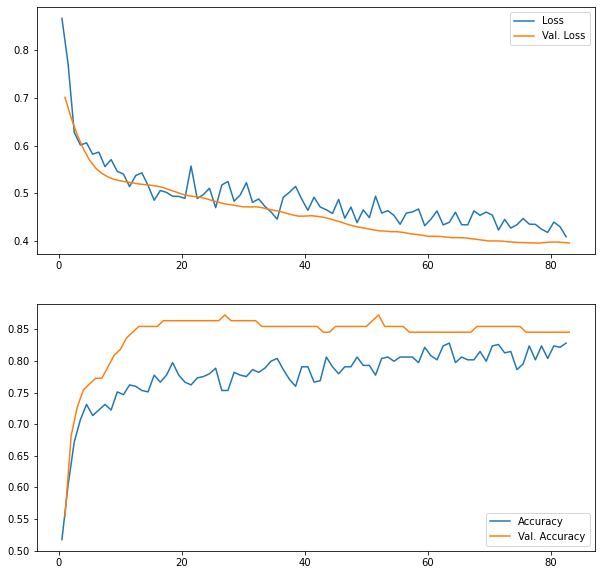

In [19]:
plot_loss(history)

# Evaluate and Compare Models

In [20]:
print('RFG Valid Acc: {}'.format(rfg_valid_acc))
print('NN Valid Acc: {}'.format(history.history['val_accuracy'][-5]*100))

RFG Valid Acc: 86.36363636363636
NN Valid Acc: 84.54545736312866


# Prediction

In [21]:
#RFG
# x_test = prep_data('../input/titanic/test.csv', val_split=0, random_seed=17, mode='test')
# predictions = forest_reg.predict(x_test)
# predictions = list(map(lambda x: 0 if x<0.5 else 1, predictions)) #round predictions to 0 or 1

# output = pd.read_csv('../input/titanic/test.csv', usecols=['PassengerId'])
# output['Survived'] = predictions
# print(output)
# output.to_csv('submission.csv', index=False)

#NN
x_test = prep_data('../input/titanic/test.csv', val_split=0, random_seed=17, mode='test')
predictions = model.predict(x_test)
predictions = list(map(lambda x: 0 if x<0.5 else 1, predictions)) #round predictions to 0 or 1

output = pd.read_csv('../input/titanic/test.csv', usecols=['PassengerId'])
output['Survived'] = predictions
print(output)
output.to_csv('submission.csv', index=False)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]
